In [2]:
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import os
import sys
import scvelo as scv
scv.settings.verbosity=1
import scvi
from tqdm.notebook import tqdm
from pathlib import Path

# Jupyter stuff
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

# Paths and utils
root = Path('../')
figure_path = root / 'results/figures/Fig3/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
data_path = root / 'data/'
# BIH
tmp_path = Path('/fast/scratch/users/peidlis_c/')
utils_path = Path('/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/')
# local
tmp_path = data_path
utils_path = '/Users/stefanpeidli/work/utils/scrnaseq_utils/'
signatures_path = '/Users/stefanpeidli/work/utils/scrnaseq_signature_collection/'

sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
%matplotlib inline

# Load and process data

12081 features of mat are empty in 84791 samples, they will be ignored.
Running mlm on mat with 84794 samples and 28340 targets for 14 sources.


100%|██████████| 50/50 [03:10<00:00,  3.80s/it]


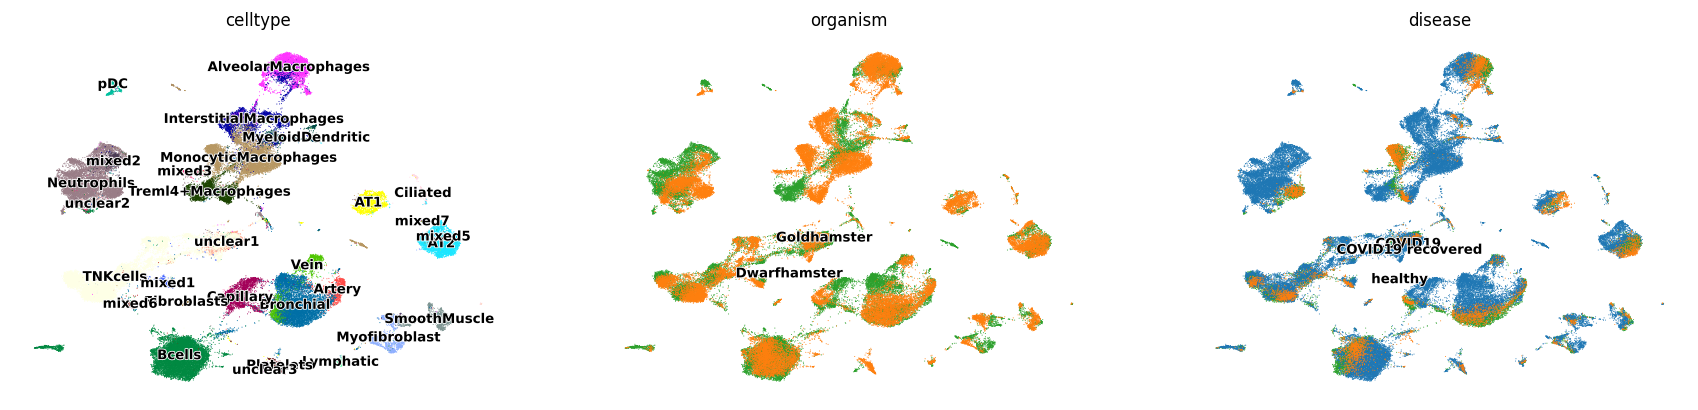

In [2]:
# hamster data
adata = sc.read("/fast/work/projects/bluethgen_landthaler/Cov19_Hamster/data/Cov19Hamster_timecourse_integrated_all.h5")

adata.obs['disease'] = 'COVID19'
adata.obs['disease'][adata.obs.time=='D0'] = 'healthy'
adata.obs['disease'][adata.obs.time=='E14'] = 'COVID19 recovered'
adata.obs = adata.obs.rename({'orig.ident': 'sample_id'}, axis=1)

# scoring
run_progeny(adata, species='mouse')
score_hallmarks(adata, subset='all', species='mouse')

scv.pl.scatter(adata, basis='umap_scVI', color=['celltype', 'organism', 'disease'], dpi=120, legend_fontsize=8, legend_loc='on data')
# save
adata.write('/fast/scratch/users/peidlis_c/cov19_hamster_data.h5')

1920 features of mat are empty in 116310 samples, they will be ignored.
Running mlm on mat with 116313 samples and 32626 targets for 14 sources.


100%|██████████| 50/50 [02:04<00:00,  2.48s/it]


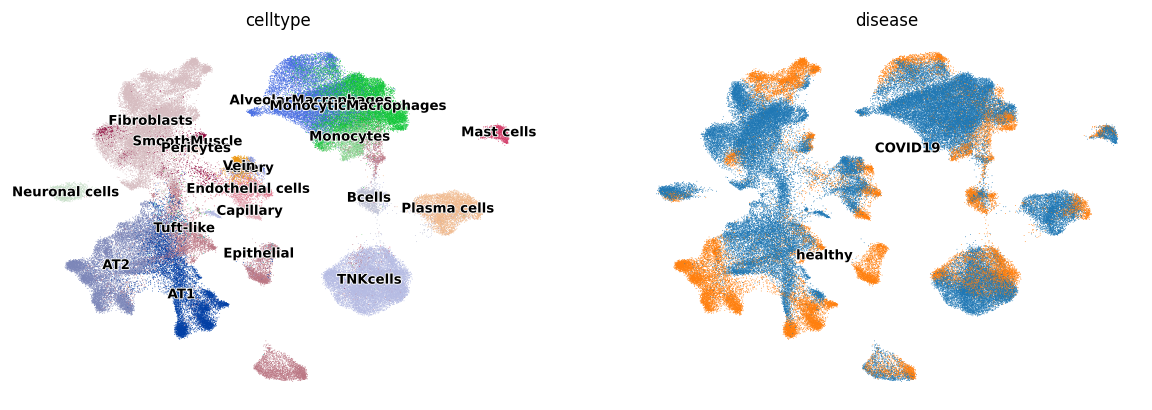

In [4]:
MelmsIzar290421_data = sc.read("/fast/work/projects/bluethgen_landthaler/Cov19_Hamster/data/ExternalData/MelmsIzar290421/MelmsIzar290421.h5")
MelmsIzar290421_data.obs['organism'] = 'human'
MelmsIzar290421_data.obs = MelmsIzar290421_data.obs.rename({'biosample_id': 'sample_id', 'cell_type_intermediate' : 'celltype', 'cell_type_fine': 'celltype_2', 'intubation_days': 'DAIS'}, axis=1)
MelmsIzar290421_data.obs['severity'] = 'critical'
MelmsIzar290421_data.obs['sample_type'] = 'tissue'
MelmsIzar290421_data.obs['outcome'] = 'deceased'
MelmsIzar290421_data.obs['3_or_5_prime']='3'
MelmsIzar290421_data.obs = MelmsIzar290421_data.obs.drop(['disease'], axis=1)  # remove duplicate
MelmsIzar290421_data.obs['disease'] = ['healthy' if x=='Control' else 'COVID19' for x in MelmsIzar290421_data.obs['group']]
MelmsIzar290421_data.obs = MelmsIzar290421_data.obs.drop(['n_counts', 'organ', 'library_preparation_protocol', 'disease__ontology_label', 'group', 'library_preparation_protocol__ontology_label',
                                                         'organ__ontology_label', 'species__ontology_label', 'species', 'donor_id', 'cell_type_main', 'initial_clustering', 'pmi_h'], axis=1)  # remove duplicate
MelmsIzar290421_data.uns['name'] = 'MelmsIzar290421'
MelmsIzar290421_data.obs['celltype_1'] = MelmsIzar290421_data.obs['celltype'].copy()
MelmsIzar290421_data.obs['celltype'] = MelmsIzar290421_data.obs['celltype_2'].replace({
    'Activated B cells': 'Bcells',
    'Adventitial FB': 'Fibroblasts',
    'Airway basal': 'Epithelial',
    'Airway ciliated': 'Epithelial',
    'Airway club': 'Epithelial',
    'Airway goblet': 'Epithelial',
    'Airway mucous': 'Epithelial',
    'Airway smooth muscle': 'SmoothMuscle',
    'Alveolar FB': 'Fibroblasts',
    'Alveolar macrophages': 'AlveolarMacrophages',
    'Arterial endothelial cells': 'Artery',
    'B cells': 'Bcells',
    'CD4+ T cells': 'TNKcells',
    'CD8+ T cells': 'TNKcells',
    'Capillary endothelial cells': 'Capillary',
    'Cycling NK/T cells': 'TNKcells',
    'Cycling epithelial': 'Epithelial',
    'Dendritic cells': 'Epithelial',
    'ECM-high epithelial': 'Epithelial',
    'Endothelial cells (general)': 'Endothelial cells',
    'Endothelial cells (other)': 'Endothelial cells',
    'Inflamed endothelial cells': 'Endothelial cells',
    'Intermediate pathological FB': 'Fibroblasts',
    'Mesothelial FB': 'Fibroblasts',
    'Monocyte-derived macrophages': 'MonocyticMacrophages',
    'Transitioning MDM': 'MonocyticMacrophages',
    'NK cells': 'TNKcells',
    'Other FB': 'Fibroblasts',
    'Pathological FB': 'Fibroblasts',
    'Pulmonary venous endothelial cells': 'Vein',
    'Systemic venous endothelial cells': 'Vein',
    'Tregs': 'TNKcells',
    'Vascular smooth muscle': 'SmoothMuscle'
})

# scoring
run_progeny(MelmsIzar290421_data, species='human')
score_hallmarks(MelmsIzar290421_data, subset='all', species='human')

# Could not find any neutros. Either dead or filtered out.
scv.pl.scatter(MelmsIzar290421_data, color=['celltype', 'disease'], dpi=120, legend_fontsize=8, legend_loc='on data')

# save
MelmsIzar290421_data.write('/fast/scratch/users/peidlis_c/MelmsIzar290421_data.h5')

8280 features of mat are empty in 70562 samples, they will be ignored.
Running mlm on mat with 70565 samples and 25258 targets for 14 sources.


100%|██████████| 50/50 [02:20<00:00,  2.82s/it]


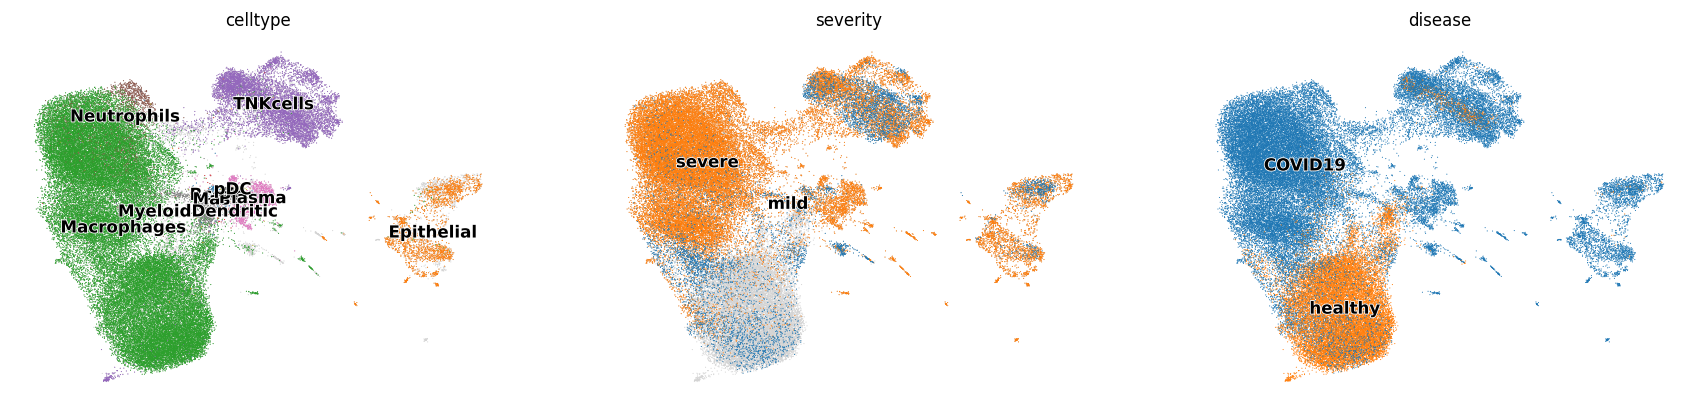

In [5]:
LiaoZhang120520_data = sc.read('/fast/work/users/peidlis_c/data/Cov19Hamster/ExternalData/LiaoZhang120520/LiaoZhang120520.h5')
LiaoZhang120520_data.obs['severity'] = ['mild' if 'mild' in x else 'severe' if 'severe' in x else None for x in LiaoZhang120520_data.obs.condition]
LiaoZhang120520_data.obs['disease'] = ['healthy' if x=='healthy' else 'COVID19' for x in LiaoZhang120520_data.obs.condition]
LiaoZhang120520_data.obs=LiaoZhang120520_data.obs.rename({'patient': 'sample_id', 'celltype_fine': 'celltype_2'}, axis=1)
LiaoZhang120520_data.obs['organism'] = 'human'
LiaoZhang120520_data.obs = LiaoZhang120520_data.obs.drop(['n_counts', 'condition'], axis=1)  # remove duplicate
LiaoZhang120520_data.obs['sample_type'] = 'BALF'
LiaoZhang120520_data.uns['name'] = 'LiaoZhang120520'
LiaoZhang120520_data.obs['celltype'] = LiaoZhang120520_data.obs['celltype'].replace({
    'B': 'Bcells',
    'Macrophages': 'Macrophages',
    'NK': 'TNKcells',
    'Neutrophil': 'Neutrophils',
    'T': 'TNKcells',
    'mDC': 'MyeloidDendritic',
})

# scoring
run_progeny(LiaoZhang120520_data, species='human')
score_hallmarks(LiaoZhang120520_data, subset='all', species='human')

# plot
# healthy samples have NAN severity
scv.pl.scatter(LiaoZhang120520_data, color=['celltype', 'severity', 'disease'], dpi=120, legend_loc='on data')

# save
LiaoZhang120520_data.write('/fast/scratch/users/peidlis_c/LiaoZhang120520_data.h5')

2022-12-08 17:27:43,325 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2022-12-08 17:28:43,642 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2022-12-08 17:29:43,444 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2022-12-08 17:30:43,982 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2022-12-08 17:31:43,080 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


5547 features of mat are empty in 92537 samples, they will be ignored.
Running mlm on mat with 92540 samples and 27207 targets for 14 sources.


100%|██████████| 50/50 [02:48<00:00,  3.37s/it]


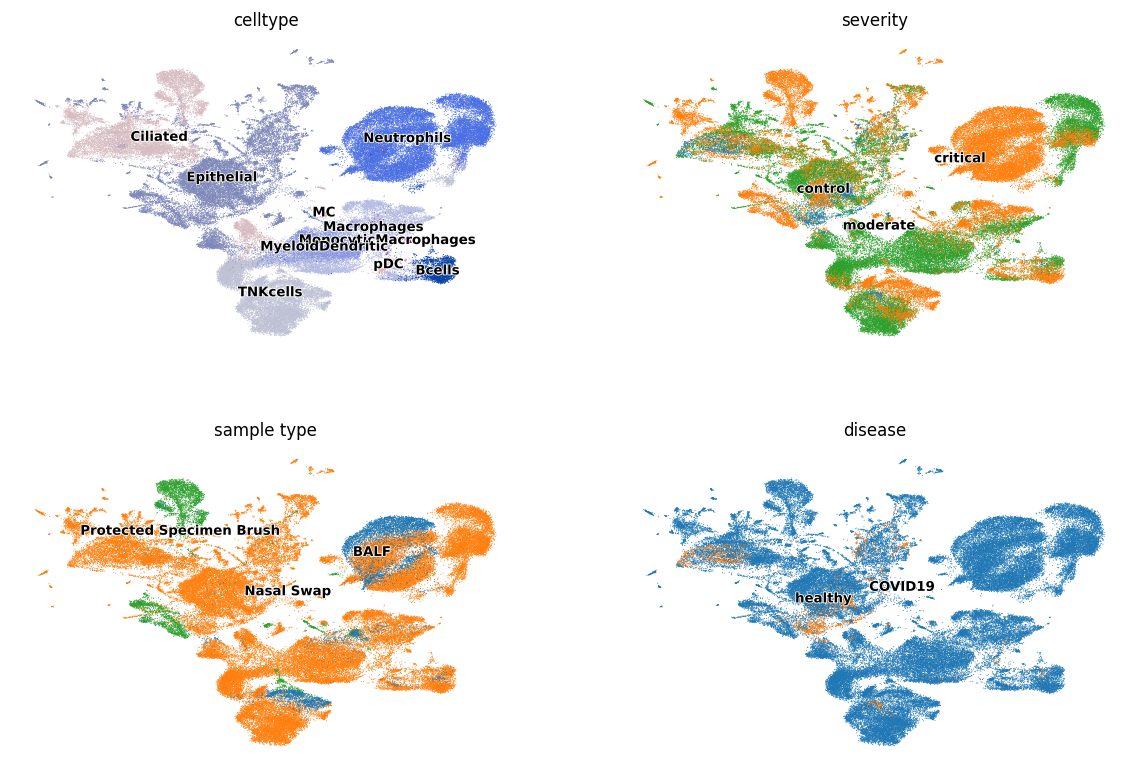

In [6]:
ChuaEils290620_data = sc.read('/fast/work/users/peidlis_c/data/Cov19Hamster/ExternalData/ChuaEils290620/ChuaEils290620.h5')

# rename and harmonize metadata
ChuaEils290620_data.obs['sample_type'] = ['BALF' if x=='BL' else 'Nasal Swap' if x=='NS' else 'Protected Specimen Brush' for x in ChuaEils290620_data.obs.location]
ChuaEils290620_data.obs = ChuaEils290620_data.obs.drop(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'series', 'location', 'virus_pos'], axis=1)  # virus_pos useless
ChuaEils290620_data.obs = ChuaEils290620_data.obs.rename({'dps': 'DASO', 'sample': 'sample_id', 'infection': 'disease'}, axis=1)
ChuaEils290620_data.obs['organism'] = 'human'
ChuaEils290620_data.obs.disease = ChuaEils290620_data.obs.disease.cat.rename_categories({'SARS-CoV-2': 'COVID19'})
ChuaEils290620_data.uns['name'] = 'ChuaEils290620'

# correction
ChuaEils290620_data.obs.patient = [x.split('_')[0] for x in ChuaEils290620_data.obs.sample_id]
ChuaEils290620_data.obs.disease[ChuaEils290620_data.obs.disease.isna()] = 'COVID19'
ChuaEils290620_data.obs.severity[ChuaEils290620_data.obs.patient.isin(['BIH-CoV-04', 'BIH-CoV-01'])] = 'critical'

# harmonize cell types
ChuaEils290620_data.obs['celltype'] = ChuaEils290620_data.obs['celltype'].replace({
    'B cell': 'Bcells',
    'Basal': 'Epithelial',
    'CTL': 'TNKcells',
    'Ciliated': 'Ciliated',
    'Ciliated-diff': 'Ciliated',
    'FOXN4': 'Epithelial',
    'IRC': 'Epithelial',
    'Ionocyte': 'Epithelial',
    'MoD-Ma': 'MonocyticMacrophages',
    'NK': 'TNKcells',
    'NKT': 'TNKcells',
    'NKT-p': 'TNKcells',
    'Neu': 'Neutrophils',
    'Secretory': 'Epithelial',
    'Secretory-diff': 'Epithelial',
    'Squamous': 'Epithelial',
    'Treg': 'TNKcells',
    'moDC': 'MyeloidDendritic',
    'nrMa': 'Macrophages',
    'outliers_epithelial': 'Epithelial',
    'rMa': 'Macrophages',
    'unknown_epithelial': 'Epithelial'
})

# integrate
sc.external.pp.harmony_integrate(ChuaEils290620_data, 'sample_id')
sc.pp.neighbors(ChuaEils290620_data)
sc.tl.umap(ChuaEils290620_data)

# label transfer
from sklearn.neighbors import KNeighborsClassifier
mask = ~ChuaEils290620_data.obs.celltype.isna()
X = ChuaEils290620_data.obsm['X_pca_harmony'][mask]
y = ChuaEils290620_data.obs.celltype[mask]
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X, y)
ChuaEils290620_data.obs.celltype[~mask] = neigh.predict(ChuaEils290620_data.obsm['X_pca_harmony'][~mask])

# scoring
run_progeny(ChuaEils290620_data, species='human')
score_hallmarks(ChuaEils290620_data, subset='all', species='human')

# plot
scv.pl.scatter(ChuaEils290620_data, color=['celltype', 'severity', 'sample_type', 'disease'], dpi=120, legend_loc='on data', ncols=2, legend_fontsize=8)

# save
ChuaEils290620_data.write('/fast/scratch/users/peidlis_c/ChuaEils290620_data.h5')

# Export pseudobulks

In [8]:
# infection (hamster)
adata = sc.read('/fast/scratch/users/peidlis_c/cov19_hamster_data.h5')

kwargs = {
    'keys': ['sample_id', 'disease', 'celltype'], 
    'path': '/fast/scratch/users/peidlis_c/',
    'layer': 'counts',
    'min_cells_per_group': 10
         }
export_for_deseq(adata[(adata.obs.organism=='Dwarfhamster') & (adata.obs.dosage.isin(['low dose', 'no dose']))].copy(),
                 name='hamster_dwarf_ld_disease', **kwargs)
export_for_deseq(adata[(adata.obs.organism=='Dwarfhamster') & (adata.obs.dosage.isin(['high dose', 'no dose']))].copy(),
                 name='hamster_dwarf_hd_disease', **kwargs)
export_for_deseq(adata[adata.obs.organism=='Goldhamster'].copy(), 
                 name='hamster_gold_disease', **kwargs)

432it [00:02, 204.43it/s]
432it [00:02, 201.75it/s]
1260it [00:07, 169.83it/s]


In [9]:
# severity / infection (human)
MelmsIzar290421_data = sc.read('/fast/scratch/users/peidlis_c/MelmsIzar290421_data.h5')
LiaoZhang120520_data = sc.read('/fast/scratch/users/peidlis_c/LiaoZhang120520_data.h5')
LiaoZhang120520_data.obs.severity=LiaoZhang120520_data.obs.severity.astype(str).replace({'nan': 'healthy'})
ChuaEils290620_data = sc.read('/fast/scratch/users/peidlis_c/ChuaEils290620_data.h5')

kwargs = {
    'keys': ['sample_id', 'disease', 'severity', 'celltype'], 
    'path': '/fast/scratch/users/peidlis_c/',
    'layer': 'counts',
    'min_cells_per_group': 10
         }
export_for_deseq(MelmsIzar290421_data, name='MelmsIzar290421', **kwargs)
export_for_deseq(LiaoZhang120520_data, name='LiaoZhang120520', **kwargs)
export_for_deseq(ChuaEils290620_data, name='ChuaEils290620', **kwargs)

1026it [00:13, 77.81it/s]
720it [00:05, 138.84it/s]
2160it [00:19, 112.61it/s]


In [11]:
# severity (hamster)
adata = sc.read('/fast/scratch/users/peidlis_c/cov19_hamster_data.h5')

kwargs = {
    'keys': ['sample_id', 'organism', 'celltype'], 
    'path': '/fast/scratch/users/peidlis_c/',
    'layer': 'counts',
    'min_cells_per_group': 10
         }
export_for_deseq(adata[adata.obs.time.isin(['D2', 'D3', 'D5'])].copy(),
                 name='hamster_all_infected', **kwargs)

1260it [00:09, 128.03it/s]
